# Bringing Better Healthcare to Developing Countries
### Problem Statement 3 - Achieving <b>GOOD HEALTH & WELL-BEING</b> in the World!
--------
### Using Reinforcement Learning (RL) to optimize Dynamic Treatment Regimes (DTRs) for HIV patients in developing countries

By Baby Boss (Xiaoxuan, Voan, Enoch, Rui Bin, Leo)

<br>

Synthetic dataset can be found [here](https://figshare.com/articles/dataset/The_Health_Gym_v2_0_Synthetic_Antiretroviral_Therapy_ART_for_HIV_Dataset/22827878).
This dataset was synthentically generated using GANs in [this paper](https://arxiv.org/pdf/2208.08655.pdf).

More information on the original dataset, <i>The EuResist Database</i>, can be found [here](https://www.genafor.org/arevir2007/presentation/2/20-04-2007/EuResistDB_forArevirMeetingApril202007.pdf).

*Due to lack of time to gain access to the original database, we decided to use the synthetic dataset instead.

--------

<br>

| Title | Category | Meaning | Comments |
| ----- | -------- | ------- | ------- |
| VL | Patient's Health Status | Viral Load (copies/mL)  |
| CD4 | Patient's Health Status | Absolute Count for CD4 (cells/mm<sup>3</sup>) |
| Rel CD4 | Patient's Health Status | Relative Count for CD4 (cells/mm<sup>3</sup>) |
| Base Drug Combo | HIV Treatments | FTC + TDF <br> 3TC + ABC <br> FTC + TAF <br> DRV + FTC + TDF <br> FTC + RTVB + TDF <br> Other | Class 0 = FTC + TDF<br>Class 1 = 3TC + ABC<br>Class 2 = DRV + FTC + TDF<br>Class 3 = Other<br>Class 4 = FTC + RTVB + TDF<br>Class 5 = FTC + TAF |
| Comp. INI | HIV Treatments | Complimentary INI (Integrase Inhibitor) | Class 0 = Not Applied<br>Class 1 = DTG<br>Class 2 = EVG<br>Class 3 = DTG |
| Comp. NNRTI | HIV Treatments | Complimentary NNRTI (Nucleotide Reverse Transcriptase Inhibitors)| Class 0 = Not Applied<br>Class 1 = RPV<br>Class 2 = EFV<br>Class 3 = NVP |
| Extra PI | HIV Treatments | Extra Protease Inhibitors | Class 0 = Not Applied<br>Class 1 = ATV<br>Class 2 = RTVB<br>Class 3 = RTV<br>Class 4 = LPV<br>Class 5 = DRV |
| Extra pk-En | HIV Treatments | Extra pk-Enhancer | Class 0 = False<br>Class 1 = True |
| VL (M) | Binary Measurement | Whether VL was measured in the original dataset | Class 0 = False<br>Class 1 = True |
| CD4 (M) | Binary Measurement | Whether CD4 was measured in the original dataset | Class 0 = False<br>Class 1 = True |
| Drug (M) | Binary Measurement | Whether Drug was measured in the original dataset | Class 0 = False<br>Class 1 = True |
| PatientID | Patient's Identifier | Patient Identification Number | Range between 0 to 8915 |
| Timestep | Patient's Identifier | Patient's Visit Sorted by Time | Range between 0 to 59 |
| Gender | Patient's Identifier | Male<br>Female | Class 0 = Male<br>Class 1 = Female |
| Ethnic (Ethnicity) | Patient's Identifier | Asian<br>African<br>Caucasian<br>Other | Class 0 = Asian<br>Class 1 = Afro<br>Class 2 = Caucasian<br>Class 3 = Other |


<br>

---------

In [1]:
# Install the required packages & Download the dataset
# %pip install pandas gym matplotlib numpy scikit-learn
# %wget -O HIV_dataset.csv https://figshare.com/ndownloader/files/40584980

In [2]:
import pandas as pd
import gym
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
# Load dataset

original_data = pd.read_csv('HIV_dataset.csv')
original_data

,VL,CD4,Rel CD4,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL (M),CD4 (M),Drug (M),PatientID,Timestep
0,29.944271,793.45830,30.834505,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,1.0,1.0,0,0
1,29.241980,467.41890,30.355980,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,1
2,28.748991,465.12485,30.405320,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,2
3,28.101835,692.00690,30.248816,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,3
4,28.813837,641.75714,29.944712,1.0,3.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534955,8.633752,4061.17580,38.708908,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,55
534956,112.354550,2626.29880,22.839344,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,56
534957,9.187279,3726.58370,37.175346,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,57
534958,18.690529,2740.06540,29.395905,1.0,4.0,0.0,2.0,3.0,5.0,1.0,0.0,0.0,1.0,8915,58


In [4]:
# Preprocessing Data

# Find a suitable bin value for variables "VL" and "CD4"

# ±1 for the upper and lower limits to include all values in the bin
# Define bin boundaries for HIV VL
vl_bins = [min(original_data['VL']) - 1, 10000, 50000, max(original_data['VL']) + 1]  # Low, Medium, High

# Define bin boundaries for CD4 count
cd4_bins = [min(original_data['CD4']) - 1, 200, 500, max(original_data['CD4']) + 1]  # Low, Medium, High

def preprocess_data(dataframe):

    # To index from 0
    dataframe['Gender'] -= 1
    dataframe['Ethnic'] -= 1

    # Columns to be shifted to the end
    columns_to_shift_start = ['PatientID', 'Timestep', 'Gender', 'Ethnic']
    columns_to_shift_end = ['VL', 'CD4', 'Rel CD4']

    # Drop "Binary Measurement" columns since it does not value-add to the model
    dataframe.drop(columns=['VL (M)', 'CD4 (M)', 'Drug (M)'], inplace=True)

    # Discretize CD4 count and HIV VL
    dataframe['VL Category'] = pd.cut(dataframe['VL'], bins=vl_bins, labels=[0, 1, 2])
    dataframe['CD4 Category'] = pd.cut(dataframe['CD4'], bins=cd4_bins, labels=[0, 1, 2])
    
    
    # Create a list of columns excluding the ones to be shifted, and put the shifted columns at the end
    other_columns = [col for col in dataframe.columns if col not in columns_to_shift_start and col not in columns_to_shift_end]
    new_order = columns_to_shift_start + other_columns + columns_to_shift_end
    data_reordered = dataframe[new_order]
    

    return data_reordered

data = preprocess_data(original_data)
data

,PatientID,Timestep,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL Category,CD4 Category,VL,CD4,Rel CD4
0,0,0,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,2,29.944271,793.45830,30.834505
1,0,1,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,1,29.241980,467.41890,30.355980
2,0,2,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,1,28.748991,465.12485,30.405320
3,0,3,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,2,28.101835,692.00690,30.248816
4,0,4,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,2,28.813837,641.75714,29.944712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534955,8915,55,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,8.633752,4061.17580,38.708908
534956,8915,56,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,112.354550,2626.29880,22.839344
534957,8915,57,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,9.187279,3726.58370,37.175346
534958,8915,58,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,18.690529,2740.06540,29.395905


In [5]:
# Check data distribution

data.describe()

,PatientID,Timestep,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL,CD4,Rel CD4
count,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000,534960.000000
mean,4457.500000,29.500000,0.136945,2.486092,1.021194,2.166691,2.375819,4.180348,0.066876,7041.119417,823.080891,36.352855
std,2573.829889,17.318118,0.343789,0.783357,1.311942,1.257013,0.847216,1.635013,0.249807,18240.801089,1250.245010,30.404427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101498,7.962432,1.871511
25%,2228.750000,14.750000,0.000000,2.000000,0.000000,1.000000,2.000000,5.000000,0.000000,10.490656,272.852865,17.461661
50%,4457.500000,29.500000,0.000000,3.000000,1.000000,3.000000,3.000000,5.000000,0.000000,38.783188,466.403180,27.733725
75%,6686.250000,44.250000,0.000000,3.000000,1.000000,3.000000,3.000000,5.000000,0.000000,778.271910,859.435142,44.152004
max,8915.000000,59.000000,1.000000,3.000000,5.000000,3.000000,3.000000,5.000000,1.000000,97566.414000,42475.200000,586.634600


In [6]:
# Check for any missing values

def check_missing_values(df):
    if any(df.isna().any()):
        return "There are missing values in the dataset."
    else:
        return "There are no missing values in the dataset."
    
def test_preprocess(df):
    if (df['Gender'] >= 0).all() and (df['Ethnic'] >= 0).all():
        return "Preprocessing is successful."
    else:
        return "Preprocessing is not successful. Rerun the notebook from the start."

print(check_missing_values(data))
print(test_preprocess(data))

There are no missing values in the dataset.
Preprocessing is successful.


## Data Visualization

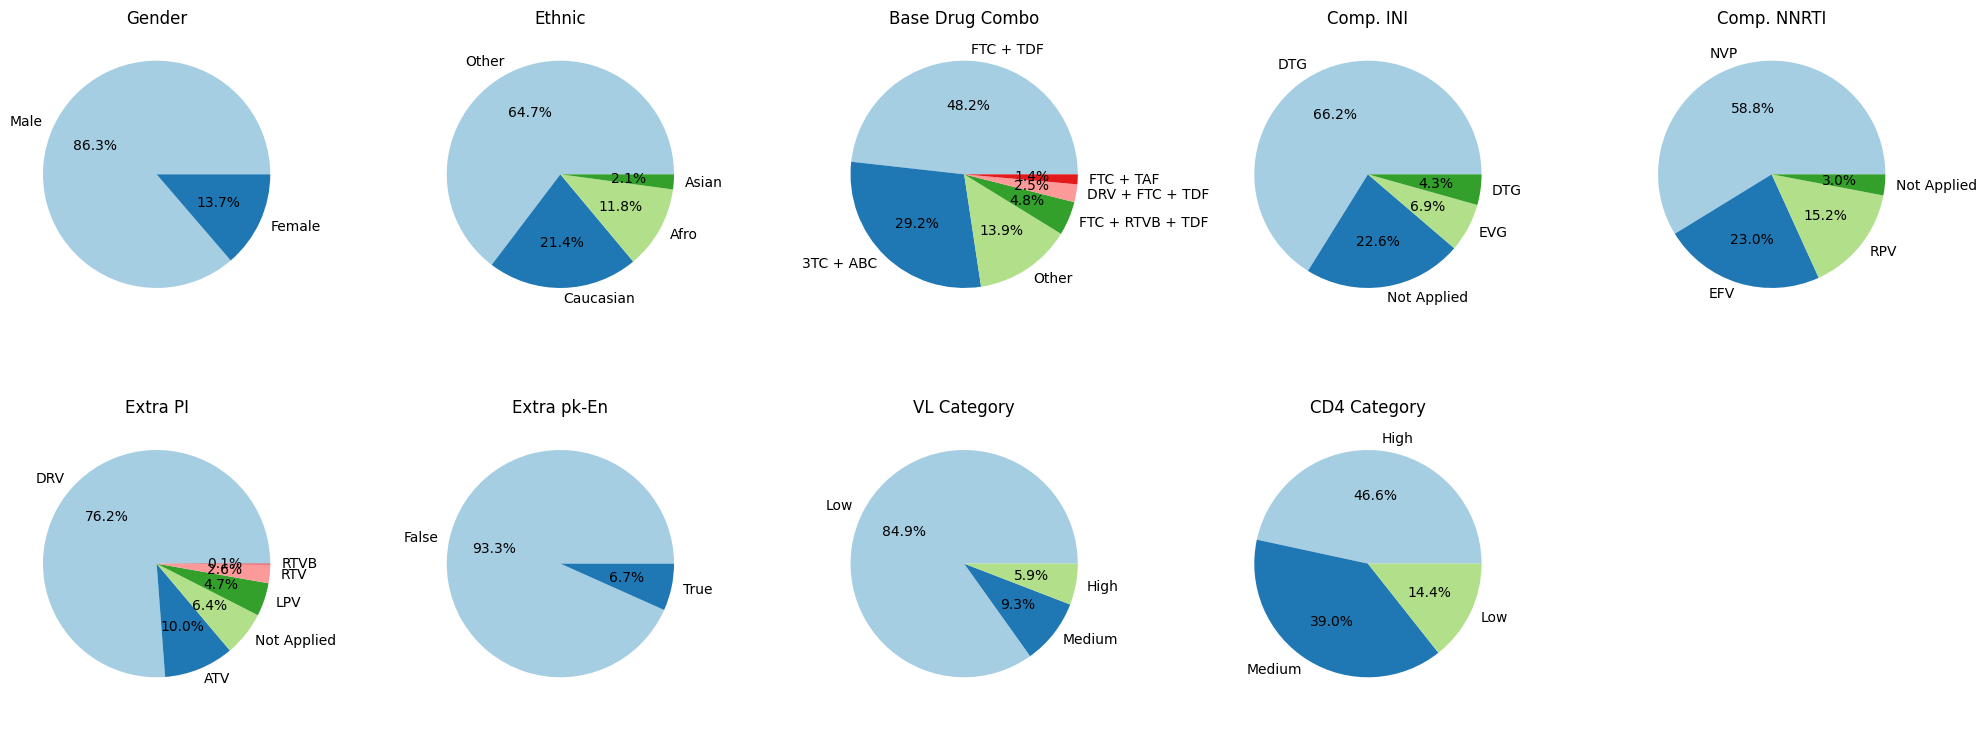

In [7]:
class_names = {
    "Gender": {0: "Male", 1: "Female"},
    "Ethnic": {0: "Asian", 1: "Afro", 2: "Caucasian", 3: "Other"},
    "Base Drug Combo": {0: "FTC + TDF", 1: "3TC + ABC", 2: "DRV + FTC + TDF",
                        3: "Other", 4: "FTC + RTVB + TDF", 5: "FTC + TAF"},
    "Comp. INI": {0: "Not Applied", 1: "DTG", 2: "EVG", 3: "DTG"},
    "Comp. NNRTI": {0: "Not Applied", 1: "RPV", 2: "EFV", 3: "NVP"},
    "Extra PI": {0: "Not Applied", 1: "ATV", 2: "RTVB", 3: "RTV", 4: "LPV", 5: "DRV"},
    "Extra pk-En": {0: "False", 1: "True"},
    "VL Category": {0: "Low", 1: "Medium", 2: "High"},
    "CD4 Category": {0: "Low", 1: "Medium", 2: "High"},
}

def visualize_data(data):
    # Create a list of columns to ignore
    ignore_col = ["VL", "CD4", "Rel CD4", "PatientID",
                  "Timestep"]

    num_cols = len(data.columns) - len(ignore_col)
    num_rows = 2
    fig, axes = plt.subplots(num_rows, int(num_cols / num_rows) + 1, figsize=(20, 8))

    axes = axes.flatten()

    subplot_index = 0

    # Iterate over columns and plot pie charts
    for column in data.columns:
        if column in ignore_col:
            continue
        counts = data[column].value_counts()
        # Access the appropriate subplot
        ax = axes[subplot_index] if num_cols > 1 else axes
        labels = [class_names[column][label] for label in counts.index]
        ax.pie(counts, labels=labels, autopct='%1.1f%%',
               colors=plt.cm.Paired.colors)

        ax.set_title(column)
        subplot_index += 1

    axes[-1].set_axis_off() # Hide the last subplot
    plt.tight_layout()
    plt.show()
    
visualize_data(data)

In [8]:
# Plotting Time-Series Functions

def plot_time_series(df, patient_id):
    # Filter DataFrame based on patient_id
    patient_data = df[df['PatientID'] == patient_id]


    # Plot time-series data
    plt.figure(figsize=(10, 6))
    plt.plot(patient_data['Timestep'] + 1, patient_data['VL'], label='VL')
    plt.plot(patient_data['Timestep'] + 1, patient_data['CD4'], label='CD4')
    plt.plot(patient_data['Timestep'] + 1,
             patient_data['Rel CD4'], label='Rel CD4')

    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.title(f'Time Series Data for Patient {patient_id}')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_vl(data, patient_id, color="blue"):
    # Filter DataFrame based on patient_id
    patient_data = data[data['PatientID'] == patient_id]

    # Plot VL time-series data
    plt.plot(patient_data['Timestep'], patient_data['VL'],
             label=f'Patient {patient_id}: VL', color=color)

    plt.xlabel('Timestep')
    plt.ylabel('VL Value')
    plt.title(f'VL Time Series Data for Patient {patient_id}')
    plt.grid(True)
    plt.show()


def plot_cd4(data, patient_id, color="orange"):
    # Filter DataFrame based on patient_id
    patient_data = data[data['PatientID'] == patient_id]

    # Plot CD4 time-series data
    plt.plot(patient_data['Timestep'], patient_data['CD4'],
             label=f'Patient {patient_id}: CD4', color=color)

    plt.xlabel('Timestep')
    plt.ylabel('CD4 Value')
    plt.title(f'CD4 Time Series Data for Patient {patient_id}')
    plt.grid(True)
    plt.show()


def plot_rel_cd4(data, patient_id, color="green"):
    # Filter DataFrame based on patient_id
    patient_data = data[data['PatientID'] == patient_id]

    # Plot Rel CD4 time-series data
    plt.plot(patient_data['Timestep'], patient_data['Rel CD4'],
             label=f'Patient {patient_id}: Rel CD4', color=color)

    plt.xlabel('Timestep')
    plt.ylabel('Rel CD4 Value')
    plt.title(f'Rel CD4 Time Series Data for Patient {patient_id}')
    plt.grid(True)
    plt.show()

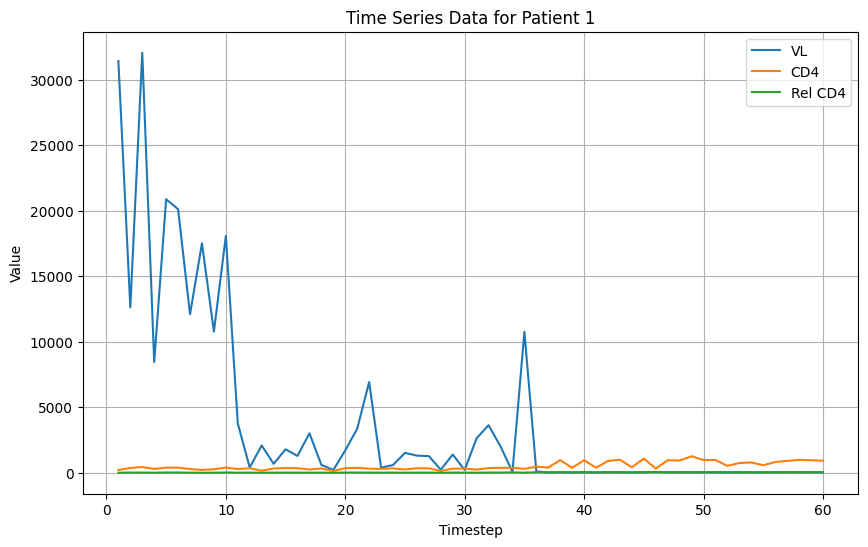

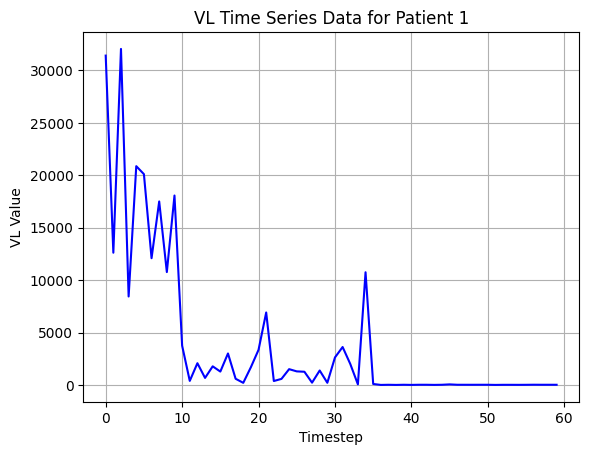

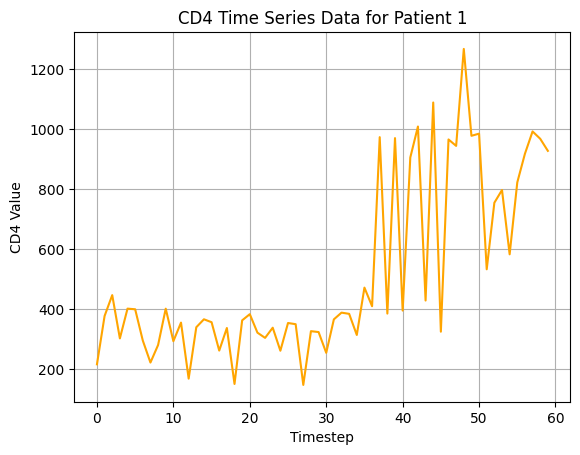

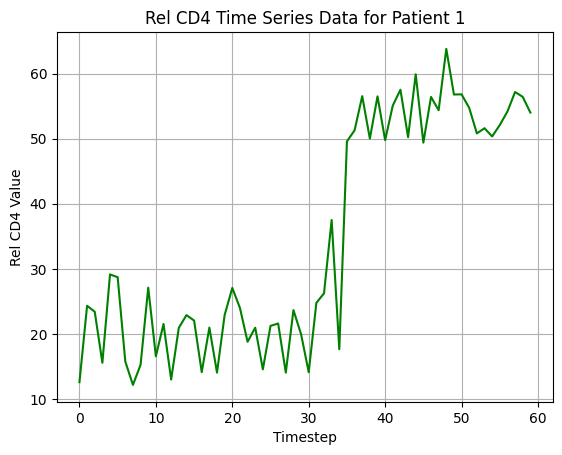

In [9]:
# Plot time-series data for a specific patient
PATIENT_ID = 1
plot_time_series(data, patient_id=PATIENT_ID)
plot_vl(data, patient_id=PATIENT_ID)
plot_cd4(data, patient_id=PATIENT_ID)
plot_rel_cd4(data, patient_id=PATIENT_ID)

## Finding Correlation between VL and CD4

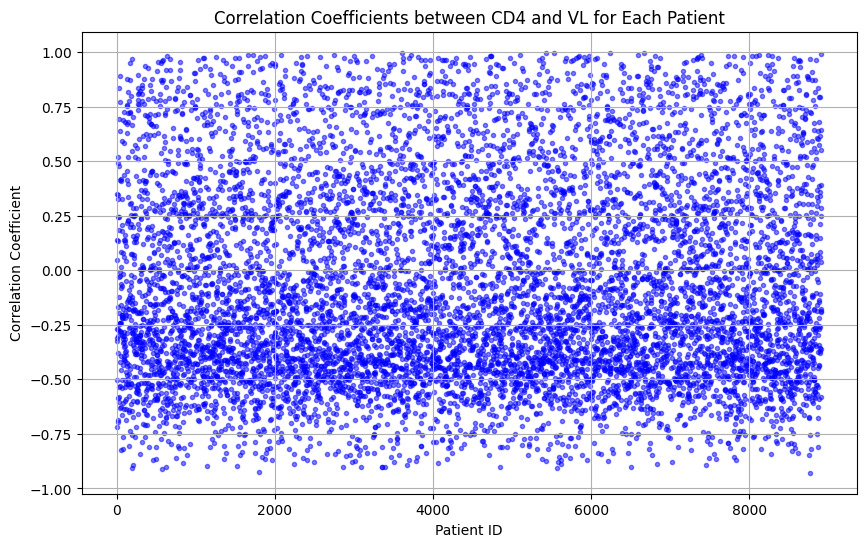

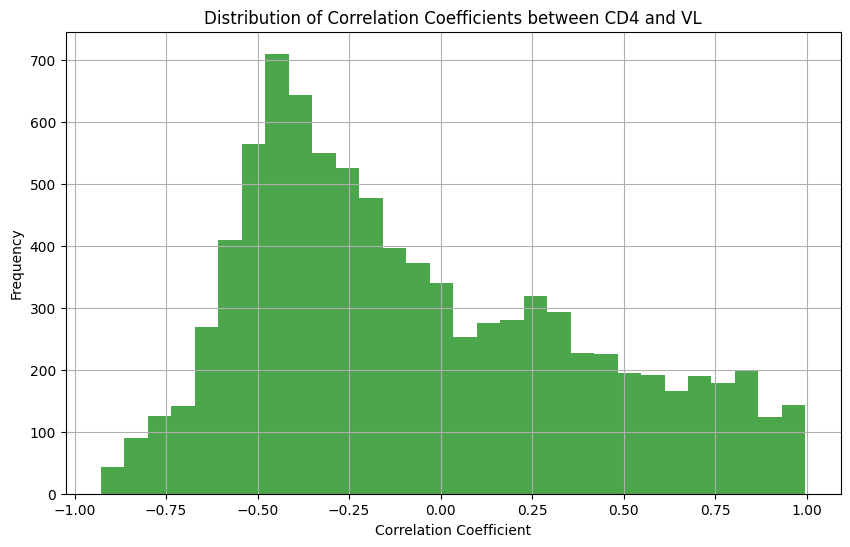

Average correlation coefficient: -0.06283802392524643


In [10]:
# Initialize an empty list to store correlation coefficients
correlation_coefficients = []
start_PATIENT_ID = min(data['PatientID'])
end_PATIENT_ID = max(data['PatientID'])

# Iterate over each patient
for patient_id in range(start_PATIENT_ID, end_PATIENT_ID):
    # Select data for the current patient
    patient_data = data[data['PatientID'] == patient_id]

    # Calculate correlation coefficient between "CD4" and "VL" for the current patient
    correlation = patient_data['CD4'].corr(patient_data['VL'])

    # Append correlation coefficient to the list
    correlation_coefficients.append(correlation)

# Calculate the average correlation coefficient across all patients
average_correlation = sum(correlation_coefficients) / len(correlation_coefficients)

# Plot scatter plot of correlation coefficients for each patient
plt.figure(figsize=(10, 6))
plt.scatter(range(start_PATIENT_ID, end_PATIENT_ID), correlation_coefficients, marker='.', color='b', alpha=0.5)
plt.xlabel('Patient ID')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients between CD4 and VL for Each Patient')
plt.grid(True)
plt.show()

# Plot histogram of correlation coefficients across all patients
plt.figure(figsize=(10, 6))
plt.hist(correlation_coefficients, bins=30, color='g', alpha=0.7)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Coefficients between CD4 and VL')
plt.grid(True)
plt.show()

print("Average correlation coefficient:", average_correlation)

## Data Preparation

Using a Train/Validation Split of 80%/20%, the data is split into training data and validation data

In [11]:
episode_length = 60
train_ratio = 0.8
num_episodes = len(data) // episode_length

# Split data into episodes
episodes = [data[i * episode_length: (i + 1) * episode_length] for i in range(num_episodes)]

# Split episodes into training and validation sets
train_episodes = episodes[:int(train_ratio * num_episodes)]
val_episodes = episodes[int(train_ratio * num_episodes):]

train_data = pd.concat(train_episodes)
val_data = pd.concat(val_episodes)

In [12]:
train_data

,PatientID,Timestep,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL Category,CD4 Category,VL,CD4,Rel CD4
0,0,0,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,2,29.944271,793.45830,30.834505
1,0,1,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,1,29.241980,467.41890,30.355980
2,0,2,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,1,28.748991,465.12485,30.405320
3,0,3,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,2,28.101835,692.00690,30.248816
4,0,4,0.0,2.0,0.0,0.0,3.0,5.0,0.0,0,2,28.813837,641.75714,29.944712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427915,7131,55,0.0,3.0,3.0,3.0,3.0,1.0,0.0,0,2,9.019238,686.44210,13.084068
427916,7131,56,0.0,3.0,3.0,3.0,3.0,1.0,0.0,0,0,7.337728,157.29823,10.377462
427917,7131,57,0.0,3.0,3.0,3.0,3.0,1.0,0.0,0,2,9.002710,672.78780,13.094154
427918,7131,58,0.0,3.0,3.0,3.0,3.0,1.0,0.0,0,1,9.058124,427.76205,10.878270


In [13]:
val_data

,PatientID,Timestep,Gender,Ethnic,Base Drug Combo,Comp. INI,Comp. NNRTI,Extra PI,Extra pk-En,VL Category,CD4 Category,VL,CD4,Rel CD4
427920,7132,0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0,2,413.160920,6426.67800,58.216522
427921,7132,1,1.0,2.0,3.0,3.0,3.0,1.0,0.0,0,2,268.867130,783.27600,30.603216
427922,7132,2,1.0,2.0,3.0,3.0,3.0,1.0,0.0,0,2,17.613990,1164.14050,58.497040
427923,7132,3,1.0,2.0,3.0,3.0,3.0,1.0,0.0,0,2,306.085970,986.80646,25.572617
427924,7132,4,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0,2,54.905506,2403.20750,38.775580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534955,8915,55,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,8.633752,4061.17580,38.708908
534956,8915,56,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,112.354550,2626.29880,22.839344
534957,8915,57,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,9.187279,3726.58370,37.175346
534958,8915,58,0.0,3.0,0.0,2.0,3.0,5.0,1.0,0,2,18.690529,2740.06540,29.395905


## Defining RL Environment and Q-Learning Agent

#### Adapted from [1]:

| HIV VL (copies/mL)          | Meaning                                           |
|---------------------|---------------------------------------------------|
| <10,000 | Low HIV virus count | 
| >10,000 & <100,000   | Medium HIV virus count | 
| >100,000 | High HIV virus count |

<br>

---------------

#### Adapted from [2]:

| CD4 Count (cells/mm<sup>3</sup>)         | Meaning                                           |
|---------------------|---------------------------------------------------|
| 500–1,600  | No HIV.          | 
| 250–500   | The immune system is compromised, possibly by HIV. | 
| Under 200 | A doctor will diagnose HIV.                      |

<br>

---------------
#### While both VL and CD4 count are great indicators in monitoring HIV treatments, <b>VL is more powerful</b> when it comes to monitoring HIV progression on patients under antiretroviral therapy (ART), which includes NNRTIs, Protease Inhibitors (PI), and Integrase Inhibitors (INI) [3].

#### Knowing this, we will increase the reward when VL is decreased as compared to an increase in CD4. 



[1]: [International Associate of Providers of AIDS Care](https://www.iapac.org/fact-sheet/viral-load/)<br>
[2]: [Healthline](https://www.healthline.com/health/hiv-aids/cd4-viral-count)<br>
[3]: [Shoko et al.](https://doi.org/10.1186/s12879-019-3781-1)

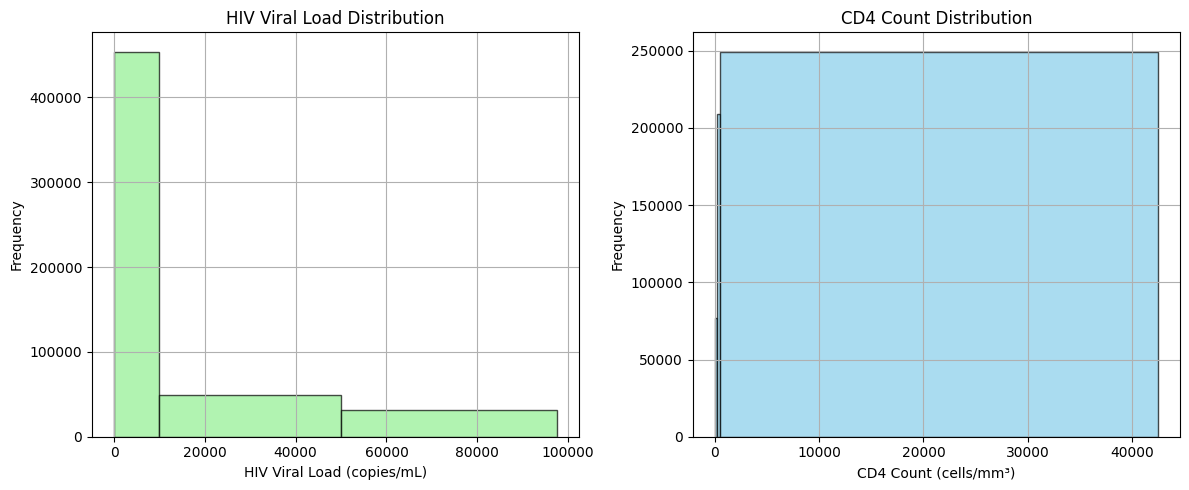

In [14]:
# We need to discretise continuous columns if they are used in either the action space or the state space


# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# HIV VL histogram
axes[0].hist(data['VL'], bins=vl_bins,
             color='lightgreen', edgecolor='black', alpha=0.7)
axes[0].set_title('HIV Viral Load Distribution')
axes[0].set_xlabel('HIV Viral Load (copies/mL)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# CD4 Count histogram
axes[1].hist(data['CD4'], bins=cd4_bins,
             color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_title('CD4 Count Distribution')
axes[1].set_xlabel('CD4 Count (cells/mm³)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)


plt.tight_layout()
plt.show()

In [15]:
def generate_action_space():
    columns = ['Base Drug Combo', 'Comp. INI',
               'Comp. NNRTI', 'Extra PI', 'Extra pk-En']
    unique_values = [list(class_names[col].keys()) for col in columns]
    
    # Generate all possible combinations of values from these columns
    action_space = list(product(*unique_values))

    # Create a mapping between each combination and a unique numeric identifier
    action_ids = {combination: idx for idx, combination in enumerate(action_space)}
    
    return action_space, action_ids
    
def generate_state_space():       
    columns = ['CD4 Category', 'VL Category', 'Gender', 'Ethnic']
    unique_values = [list(class_names[col].keys()) for col in columns]

    # Create state space
    state_space = list(product(*unique_values))
    
    # Create state IDs based on the index of each combination in the state space
    state_ids = {state: idx for idx, state in enumerate(state_space)}    
    
    return state_space, state_ids

def find_action(combo, action_dict):
    return action_dict.get(combo, None)

def find_state(combo, state_dict):
    return state_dict.get(combo, None)

def matching_tuple(tuple1, tuple2):
    return sum(1 for val1, val2 in zip(tuple1, tuple2) if val1 == val2)

In [16]:
class Environment:
    def __init__(self, patient_data):
        self.patient_data = patient_data
        self.current_step = 0
        self.reward_multipler = 10
        self.num_steps_per_patient = 60
        self.action_space, self.action_ids = generate_action_space()
        self.reverse_action_ids = {
            value: key for key, value in self.action_ids.items()}

        self.state_space, self.state_ids = generate_state_space()

        self.q_table = np.zeros((len(self.state_space), len(self.action_space)))

        # Apply the find_state function to each row and store the result in a new column called 'State'
        self.patient_data['State'] = self.patient_data.apply(lambda row: find_state((row['CD4 Category'], row['VL Category'], row['Gender'], row['Ethnic']), self.state_ids), axis=1)
    

    def step(self, state_idx, action):
        next_state_idx = state_idx
        reward = 0
        done = False
        alpha = 0.9
        beta = 0.1
        self.current_step += 1
        if self.current_step == len(self.patient_data):
            done = True
            return next_state_idx, reward, done
        # print(f"Current Step: {self.current_step}")
        # print(f"Current PatientID: {int(self.patient_data.iloc[self.current_step]['PatientID'])}")
        virus_count = self.patient_data.iloc[self.current_step]['VL']
        white_blood_cells = self.patient_data.iloc[self.current_step]['CD4']

        prev_virus_count = self.patient_data.iloc[self.current_step - 1]['VL']
        prev_white_blood_cells = self.patient_data.iloc[self.current_step - 1]['CD4']
        
        # print(f"VL: {virus_count}")
        
        # Reward Calculation
        reward = alpha * (prev_virus_count - virus_count) + beta * (white_blood_cells - prev_white_blood_cells)
        
        row = self.patient_data.iloc[self.current_step]
        action_taken = (row['Base Drug Combo'], row['Comp. INI'], row['Comp. NNRTI'], row['Extra PI'], row['Extra pk-En'])
        combo = self.reverse_action_ids.get(action, None)
        # print(f"Action Taken: {action_taken}")
        # print(f"Combo: {combo}")
        num_correct_treatment = matching_tuple(action_taken, combo)
        
        # Set a multipler to reward for all correct treatments
        # If current reward is positive, multiple the reward by the multipler
        # If current reward is negative, divide the reward by the multipler
        
        if num_correct_treatment == 5:
            if reward > 0:
                reward *= self.reward_multipler 
            else:
                reward /= self.reward_multipler
        elif num_correct_treatment == 0:
            if reward > 0:
                reward /= self.reward_multipler
            else:
                reward *= self.reward_multipler
        else: # In between 0 and 5
            if reward > 0:
                reward *= num_correct_treatment
            else:
                reward /= num_correct_treatment
            
        
        if self.current_step != 0 and self.current_step % self.num_steps_per_patient == 0:
            # print("Next Patient")
            done = True 
        else:
            # Next step is still the same patient. Therefore check the next state of the patient
            next_state_idx = int(self.patient_data.iloc[self.current_step]['State'])
            done = False
        return next_state_idx, reward, done

    def reset(self):
        # Reset the environment to its initial state
        # Return the initial state
        # print(f"Resetted to next Patient: {self.patient_data.iloc[self.current_step]['State']}")
        
        return int(self.patient_data.iloc[self.current_step]['State'])

In [17]:
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((len(state_space), len(action_space)))

    def choose_action(self, state_idx):
        if np.random.uniform(0, 1) < self.epsilon:
            # Exploration: choose a random action
            return np.random.choice([item for sublist in self.action_space for item in sublist])
        else:
            # Exploitation: choose the action with the highest Q-value
            return np.argmax(self.q_table[state_idx])

    def update_q_table(self, state_idx, action, reward, next_state_idx, done):
        td_target = reward
        if not done:
            td_target += self.discount_factor * np.max(self.q_table[next_state_idx])
        td_error = td_target - self.q_table[state_idx, action]
        self.q_table[state_idx, action] += self.learning_rate * td_error

In [18]:
class QLearningAgentNew:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((len(state_space), len(action_space)))

    def choose_action(self, state_idx):
        if np.count_nonzero(self.q_table[state_idx]) < len(self.action_space) / 2:
            # Exploration: choose a random action
            return np.random.choice([item for sublist in self.action_space for item in sublist])
        else:
            # Exploitation: choose the action with the highest Q-value
            return np.argmax(self.q_table[state_idx])

    def update_q_table(self, state_idx, action, reward, next_state_idx, done):
        td_target = reward
        if not done:
            td_target += self.discount_factor * \
                np.max(self.q_table[next_state_idx])
        td_error = td_target - self.q_table[state_idx, action]
        self.q_table[state_idx, action] += self.learning_rate * td_error

## Training

Train using 80% of the patients (n = 7132)

In [19]:
## Initialize environment and agent
env = Environment(train_data)
agent = QLearningAgent(env.state_space, env.action_space)
# print(env.action_space)
# print(env.action_ids)

In [20]:
# Train agent
total_rewards = []
cumulative_rewards = []

num_train_episodes = len(train_data) // episode_length
# num_train_episodes = 500
for episode in range(num_train_episodes):
    state = env.reset()  # Reset environment to initial state for each episode
    total_reward = 0
    done = False
    while not done:
        # print(f"State {state} with type {type(state)}")
        action = agent.choose_action(state)
        # print(f"Action: {action}")
        # print(f"Episode: {episode}")
        next_state, reward, done = env.step(state, action)
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    cumulative_rewards.append(sum(total_rewards))
    if episode % 100 == 0:
        print(f"Episode {episode + 1} / {num_train_episodes}: Total Reward = {np.max(total_reward)}")

Episode 1 / 7132: Total Reward = -13209.798952133333
Episode 101 / 7132: Total Reward = 42256.513112525696
Episode 201 / 7132: Total Reward = 12263.218587465999
Episode 301 / 7132: Total Reward = 4376.229853859999
Episode 401 / 7132: Total Reward = -10107.103073049662
Episode 501 / 7132: Total Reward = 342947.9216010497
Episode 601 / 7132: Total Reward = -364.75504562599986
Episode 701 / 7132: Total Reward = 42197.736052251676
Episode 801 / 7132: Total Reward = -2995.9645227300007
Episode 901 / 7132: Total Reward = 261384.77506754996
Episode 1001 / 7132: Total Reward = 16516.969906999995
Episode 1101 / 7132: Total Reward = 78.92282909
Episode 1201 / 7132: Total Reward = 199532.204612685
Episode 1301 / 7132: Total Reward = 27706.3192606167
Episode 1401 / 7132: Total Reward = 100365.50745690001
Episode 1501 / 7132: Total Reward = 85995.20592315002
Episode 1601 / 7132: Total Reward = 108515.19438380498
Episode 1701 / 7132: Total Reward = 256595.722253475
Episode 1801 / 7132: Total Reward 

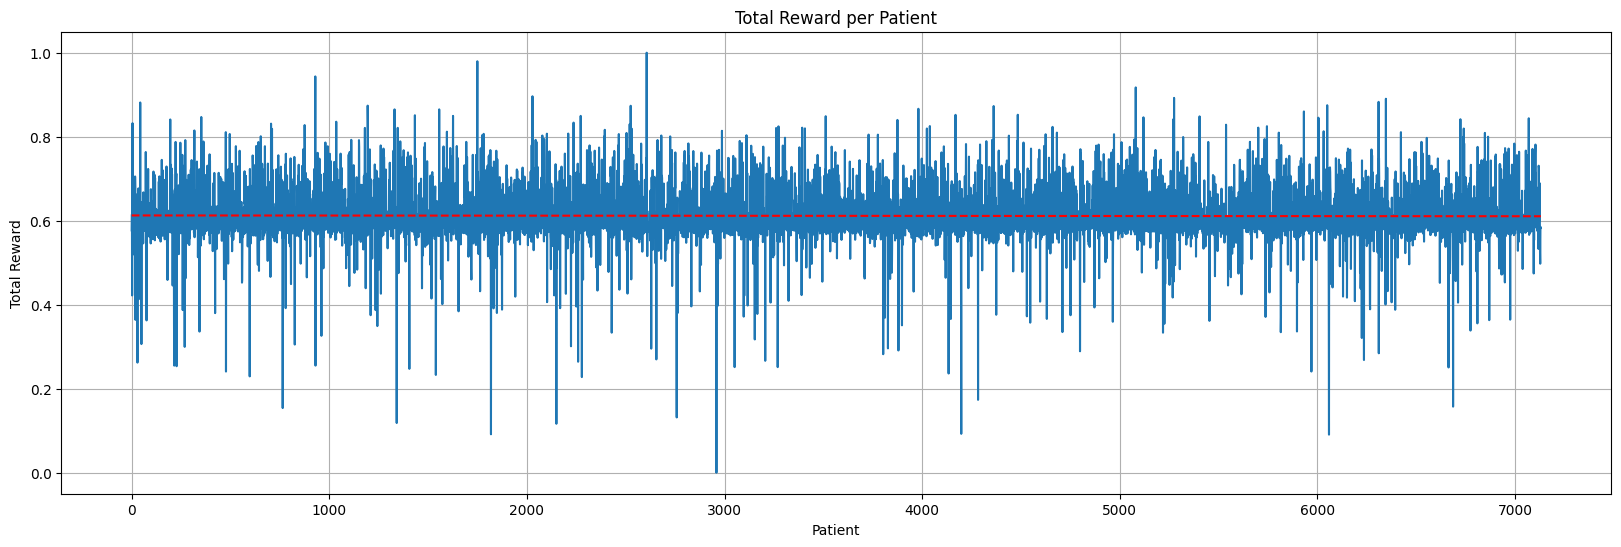

In [21]:
# Plot total rewards
plt.figure(figsize = (20, 6))
# Generate x values (Patient numbers)
x = np.arange(len(total_rewards))

min_reward = np.min(total_rewards)
max_reward = np.max(total_rewards)
normalized_rewards = (total_rewards - min_reward) / (max_reward - min_reward)


# Plot the data points
plt.plot(x, normalized_rewards, label='Total Reward')

# Fit a polynomial of degree 1 (linear regression) to the data
coefficients = np.polyfit(x, normalized_rewards, 1)
trend_line = np.poly1d(coefficients)
plt.plot(x, trend_line(x), color='red', linestyle='--', label='Trend Line')
# plt.plot(total_rewards)
plt.xlabel('Patient')
plt.ylabel('Total Reward')
plt.title('Total Reward per Patient')
plt.grid(True)
plt.show()

# Plot cumulative rewards
# plt.figure(figsize=(20, 6))
# plt.plot(cumulative_rewards, color='orange')
# plt.xlabel('Patient')
# plt.ylabel('Cumulative Reward')
# plt.title('Cumulative Reward per Patient')
# plt.grid(True)
# plt.show()

In [22]:
# Train agentNew
env = Environment(train_data)
agentNew = QLearningAgentNew(env.state_space, env.action_space)

total_rewards = []
cumulative_rewards = []


num_train_episodes = len(train_data) // episode_length
# num_train_episodes = 500
for episode in range(num_train_episodes):
    state = env.reset()  # Reset environment to initial state for each episode
    total_reward = 0
    done = False
    while not done:
        # print(f"State {state} with type {type(state)}")
        action = agentNew.choose_action(state)
        # print(f"Action: {action}")
        # print(f"Episode: {episode}")
        next_state, reward, done = env.step(state, action)
        agentNew.update_q_table(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    cumulative_rewards.append(sum(total_rewards))
    if episode % 100 == 0:
        print(f"Episode {episode + 1} / {num_train_episodes}: Total Reward = {np.max(total_reward)}")

Episode 1 / 7132: Total Reward = -27506.293291283335
Episode 101 / 7132: Total Reward = 50602.73088437168
Episode 201 / 7132: Total Reward = 5766.592793909999
Episode 301 / 7132: Total Reward = 1356.9442010100004
Episode 401 / 7132: Total Reward = -21179.931847384007
Episode 501 / 7132: Total Reward = -289417.3629972003
Episode 601 / 7132: Total Reward = -968.2467412019998
Episode 701 / 7132: Total Reward = -38471.014507935004
Episode 801 / 7132: Total Reward = -6606.926673000001
Episode 901 / 7132: Total Reward = 168347.55937235002
Episode 1001 / 7132: Total Reward = 8880.926851159998
Episode 1101 / 7132: Total Reward = -887.4174691400002
Episode 1201 / 7132: Total Reward = 156236.41427230497
Episode 1301 / 7132: Total Reward = 18286.35889584166
Episode 1401 / 7132: Total Reward = 20627.9772724
Episode 1501 / 7132: Total Reward = 61944.42029739998
Episode 1601 / 7132: Total Reward = 73656.66544570996
Episode 1701 / 7132: Total Reward = 121533.06564367501
Episode 1801 / 7132: Total Rew

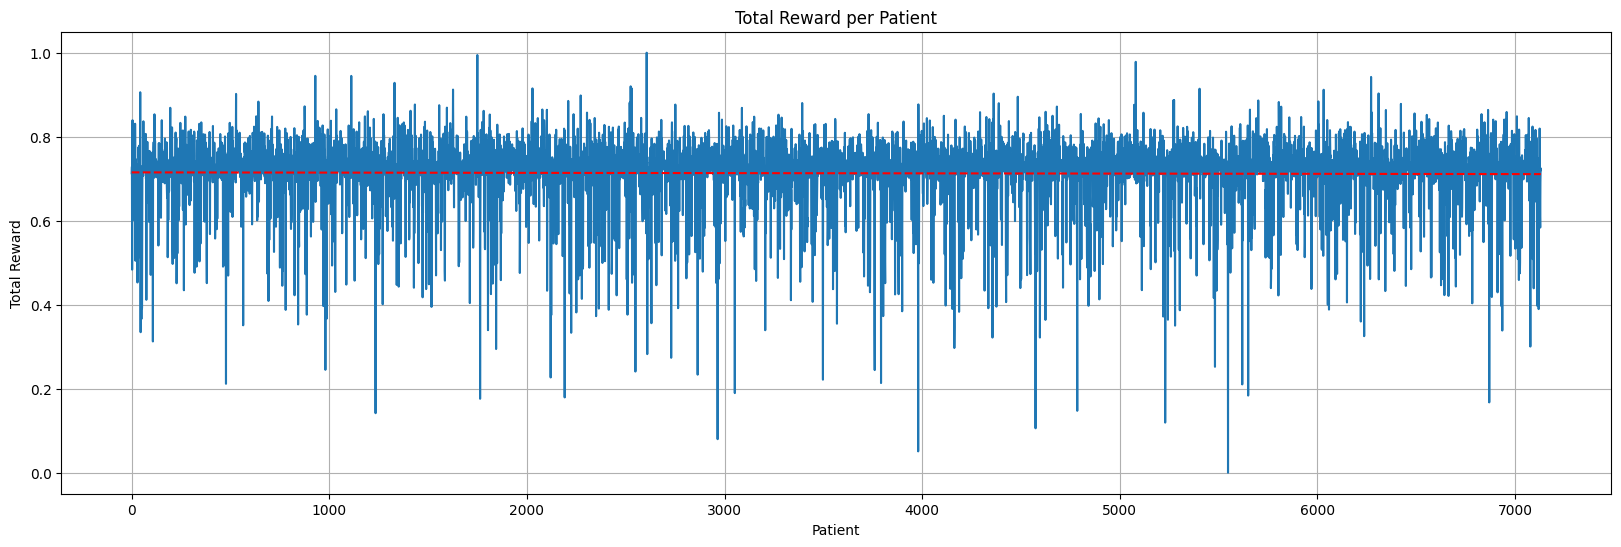

In [23]:
# Plot total rewards
plt.figure(figsize=(20, 6))
# Generate x values (Patient numbers)
x = np.arange(len(total_rewards))

min_reward = np.min(total_rewards)
max_reward = np.max(total_rewards)
normalized_rewards = (total_rewards - min_reward) / (max_reward - min_reward)


# Plot the data points
plt.plot(x, normalized_rewards, label='Total Reward')

# Fit a polynomial of degree 1 (linear regression) to the data
coefficients = np.polyfit(x, normalized_rewards, 1)
trend_line = np.poly1d(coefficients)
plt.plot(x, trend_line(x), color='red', linestyle='--', label='Trend Line')
# plt.plot(total_rewards)
plt.xlabel('Patient')
plt.ylabel('Total Reward')
plt.title('Total Reward per Patient')
plt.grid(True)
plt.show()

# Plot cumulative rewards
# plt.figure(figsize=(20, 6))
# plt.plot(cumulative_rewards, color='orange')
# plt.xlabel('Patient')
# plt.ylabel('Cumulative Reward')
# plt.title('Cumulative Reward per Patient')
# plt.grid(True)
# plt.show()

In [24]:
class QLearningEnsemble:
    def __init__(self, num_agents, env):
        self.agents = [QLearningAgent(env.state_space, env.action_space) for _ in range(num_agents)]

    def select_action(self, state):
        # Select actions from each agent
        actions = [agent.choose_action(state) for agent in self.agents]
        # Combine actions (e.g., average or voting)
        action_counts = np.bincount(actions, minlength=len(self.agents[0].action_space))
        # Select action with the most votes
        combined_action = np.argmax(action_counts)
        return combined_action

    def update(self, state, action, reward, next_state, done):
        # Update each agent
        for agent in self.agents:
            agent.update_q_table(state, action, reward, next_state, done)


env = Environment(train_data)
ensemble = QLearningEnsemble(num_agents=5, env=env)
recommended_decision = []

# Training loop
for episode in range(num_train_episodes):
    state = env.reset()  # Reset environment to initial state for each episode
    total_reward = 0
    done = False
    while not done:
        # print(f"State {state} with type {type(state)}")
        action = ensemble.select_action(state)
        # print(f"Action: {action}")
        # print(f"Episode: {episode}")
        next_state, reward, done = env.step(state, action)
        ensemble.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    cumulative_rewards.append(sum(total_rewards))
    if episode % 100 == 0:
        print(f"Episode {episode + 1} / {num_train_episodes}: Total Reward = {np.max(total_reward)}")

Episode 1 / 7132: Total Reward = -13188.142280233335
Episode 101 / 7132: Total Reward = 70844.04670656503
Episode 201 / 7132: Total Reward = 23379.63484866599
Episode 301 / 7132: Total Reward = 8376.887618126006
Episode 401 / 7132: Total Reward = -5674.602105391001
Episode 501 / 7132: Total Reward = 392822.526920533
Episode 601 / 7132: Total Reward = -37.00781991499997
Episode 701 / 7132: Total Reward = 43228.019310876676
Episode 801 / 7132: Total Reward = -6.380499074999989
Episode 901 / 7132: Total Reward = 270739.69286586664
Episode 1001 / 7132: Total Reward = 92242.94880915002
Episode 1101 / 7132: Total Reward = -195.75546871500035
Episode 1201 / 7132: Total Reward = 216205.59368297327
Episode 1301 / 7132: Total Reward = 61065.855365108306
Episode 1401 / 7132: Total Reward = 92394.97566133336
Episode 1501 / 7132: Total Reward = 13952.524480683334
Episode 1601 / 7132: Total Reward = 83029.66321373997
Episode 1701 / 7132: Total Reward = 267932.24969507504
Episode 1801 / 7132: Total R

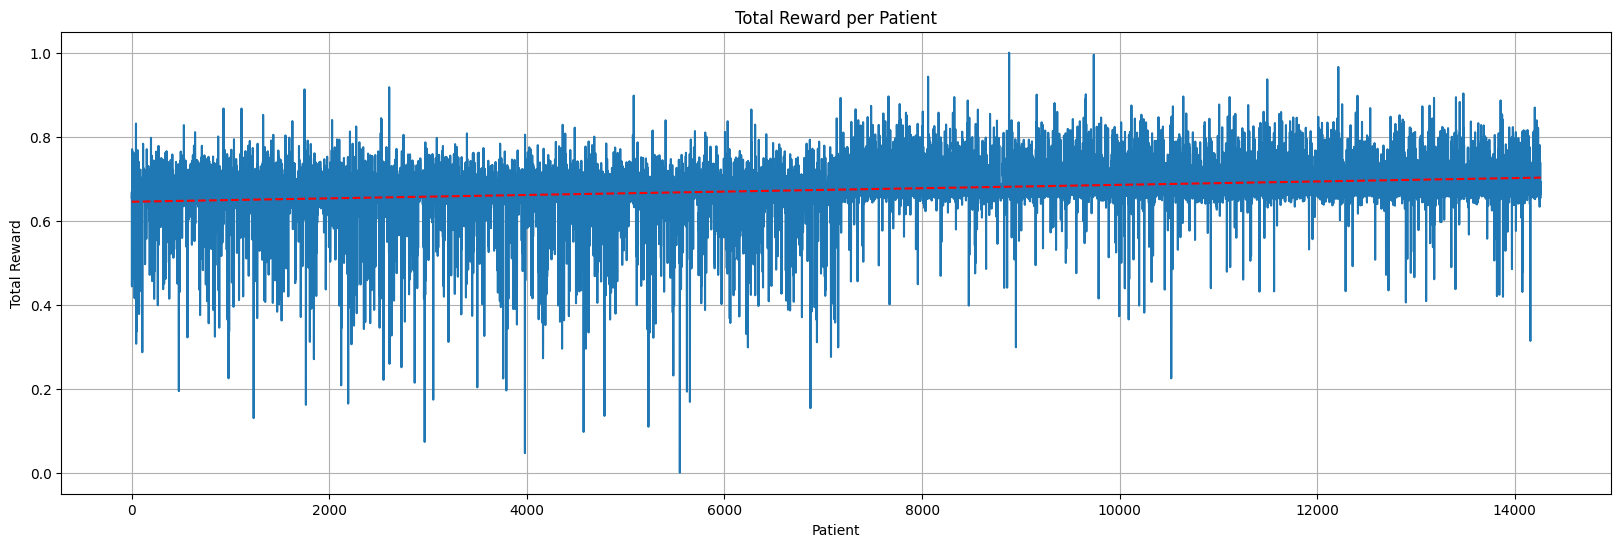

In [25]:
# Plot total rewards
# Generate x values (Patient numbers)
x = np.arange(len(total_rewards))

# Plot the data points
plt.figure(figsize=(20, 6))
min_reward = np.min(total_rewards)
max_reward = np.max(total_rewards)
normalized_rewards = (total_rewards - min_reward) / (max_reward - min_reward)


# Plot the data points
plt.plot(x, normalized_rewards, label='Total Reward')

# Fit a polynomial of degree 1 (linear regression) to the data
coefficients = np.polyfit(x, normalized_rewards, 1)
trend_line = np.poly1d(coefficients)
plt.plot(x, trend_line(x), color='red', linestyle='--', label='Trend Line')
# plt.plot(total_rewards)
plt.xlabel('Patient')
plt.ylabel('Total Reward')
plt.title('Total Reward per Patient')
plt.grid(True)
plt.show()

# Plot cumulative rewards
# plt.figure(figsize=(20, 6))
# plt.plot(cumulative_rewards, color='orange')
# plt.xlabel('Patient')
# plt.ylabel('Cumulative Reward')
# plt.title('Cumulative Reward per Patient')
# plt.grid(True)
# plt.show()

In [26]:
class Environment:
    def __init__(self, patient_data):
        self.patient_data = patient_data
        self.current_step = 0
        self.num_steps_per_patient = 60
        self.reward_multipler = 10
        self.action_space, self.action_ids = generate_action_space()
        self.reverse_action_ids = {value: key for key, value in self.action_ids.items()}
        self.state_space, self.state_ids = generate_state_space()

        self.q_table = np.zeros(
            (len(self.state_space), len(self.action_space)))

        # Apply the find_state function to each row and store the result in a new column called 'State'
        self.patient_data['State'] = self.patient_data.apply(lambda row: find_state(
            (row['CD4 Category'], row['VL Category'], row['Gender'], row['Ethnic']), self.state_ids), axis=1)

    

    def step(self, state_tensor, action):
        next_state_tensor = state_tensor
        reward = 0
        done = False
        alpha = 0.9
        beta = 0.1
        self.current_step += 1
        if self.current_step == len(self.patient_data):
            done = True
            return next_state_idx, reward, done
        # print(f"Current Step: {self.current_step}")
        # print(f"Current PatientID: {int(self.patient_data.iloc[self.current_step]['PatientID'])}")
        virus_count = self.patient_data.iloc[self.current_step]['VL']
        white_blood_cells = self.patient_data.iloc[self.current_step]['CD4']

        prev_virus_count = self.patient_data.iloc[self.current_step - 1]['VL']
        prev_white_blood_cells = self.patient_data.iloc[self.current_step - 1]['CD4']

        # print(f"VL: {virus_count}")

        # Reward Calculation
        reward = alpha * (prev_virus_count - virus_count) + \
            beta * (white_blood_cells - prev_white_blood_cells)

        row = self.patient_data.iloc[self.current_step]
        action_taken = (row['Base Drug Combo'], row['Comp. INI'],
                        row['Comp. NNRTI'], row['Extra PI'], row['Extra pk-En'])
        combo = self.reverse_action_ids.get(action, None)
        # print(f"Action Taken: {action_taken}")
        # print(f"Combo: {combo}")
        num_correct_treatment = matching_tuple(action_taken, combo)

        # Set a multipler to reward for all correct treatments
        # If current reward is positive, multiple the reward by the multipler
        # If current reward is negative, divide the reward by the multipler

        if num_correct_treatment == 5:
            if reward > 0:
                reward *= self.reward_multipler
            else:
                reward /= self.reward_multipler
        elif num_correct_treatment == 0:
            if reward > 0:
                reward /= self.reward_multipler
            else:
                reward *= self.reward_multipler
        else:  # In between 0 and 5
            if reward > 0:
                reward *= num_correct_treatment
            else:
                reward /= num_correct_treatment

        
        
        if self.current_step != 0 and self.current_step % self.num_steps_per_patient == 0:
            # print("Next Patient")
            done = True 
        else:
            next_state_idx = int(
                self.patient_data.iloc[self.current_step]['State'])
            done = False
        
        return next_state_tensor, reward, done

    def reset(self):
        # Reset the environment to its initial state
        # Return the initial state
        # print(f"Resetted to next Patient: {self.current_step-1 // self.num_steps_per_patient}")
        
        state_val = int(self.patient_data.iloc[self.current_step]['State'])
        state_tensor = np.zeros((1, 72))
        state_tensor[0, state_val] = 1

        return state_tensor

In [27]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, action_dim)
        self.fc_log_std = nn.Linear(hidden_size, action_dim)

    def forward(self, state):
        # print(f"State Shape in Actor: {state.shape}")
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        mu = self.fc_mu(x)
        log_std = self.fc_log_std(x)
        return mu, log_std


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        # print(f"State in Critic: {state}")
        # print(f"Action in Critic: {action}")
        # print(f"State Shape in Critic: {state.shape}")
        # print(f"Action Shape in Critic: {action.shape}")
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.fc3(x)
        return value


class SACAgent:
    def __init__(self, state_dim, action_dim, hidden_size=256, alpha=0.2, gamma=0.99, tau=0.005, lr=3e-4):
        self.actor = Actor(state_dim, action_dim, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic1 = Critic(state_dim, action_dim, hidden_size).to(device)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=lr)
        self.critic2 = Critic(state_dim, action_dim, hidden_size).to(device)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=lr)
        self.target_critic1 = Critic(
            state_dim, action_dim, hidden_size).to(device)
        self.target_critic1.load_state_dict(self.critic1.state_dict())
        self.target_critic2 = Critic(
            state_dim, action_dim, hidden_size).to(device)
        self.target_critic2.load_state_dict(self.critic2.state_dict())
        self.log_alpha = torch.tensor(
            np.log(alpha), requires_grad=True, device=device, dtype=torch.float32)
        self.target_entropy = -action_dim
        self.gamma = gamma
        self.tau = tau

    def select_action(self, state):
        with torch.no_grad():
            # state = state.unsqueeze(0)
            # print(state.shape)
            mu, log_std = self.actor(state)
            std = torch.exp(log_std)
            normal = Normal(mu, std)
            z = normal.sample()
            action = torch.tanh(z)
            return action.cpu().numpy()

    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
              
        state = torch.FloatTensor(state_batch).to(device)
        action = torch.FloatTensor(action_batch).to(device)
        reward = torch.FloatTensor([reward_batch]).to(device)
        next_state = torch.FloatTensor(next_state_batch).to(device)
        done = torch.FloatTensor(int(done_batch)).unsqueeze(1).to(device)
        # print(f"Next_state: {next_state}")
        # print(f"Next_state Shape: {next_state.shape}")
        # print(f"Done Shape: {done.shape}")
        # print(f"Reward Shape: {reward.shape}")

        # Update critic networks
        target_q = reward + self.gamma * (1 - done) * torch.min(
            self.target_critic1(next_state, self.actor(next_state)[0]),
            self.target_critic2(next_state, self.actor(next_state)[0])
        )
        q1_loss = nn.MSELoss()(self.critic1(state, action), target_q.detach())
        q2_loss = nn.MSELoss()(self.critic2(state, action), target_q.detach())
        self.critic1_optimizer.zero_grad()
        q1_loss.backward()
        self.critic1_optimizer.step()
        self.critic2_optimizer.zero_grad()
        q2_loss.backward()
        self.critic2_optimizer.step()

        # Update actor network
        mu, log_std = self.actor(state)
        std = torch.exp(log_std)
        normal = Normal(mu, std)
        z = normal.sample()
        action_pi = torch.tanh(z)
        log_prob = normal.log_prob(z) - torch.log(1 - action_pi.pow(2) + 1e-6)
        q1_pi = self.critic1(state, action_pi)
        q2_pi = self.critic2(state, action_pi)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (torch.exp(self.log_alpha) * log_prob - q_pi).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update temperature parameter alpha
        alpha_loss = -(torch.exp(self.log_alpha) *
                       (log_prob + self.target_entropy).detach()).mean()
        self.log_alpha.grad = None
        alpha_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
            target_param.data.copy_(
                self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
            target_param.data.copy_(
                self.tau * param.data + (1 - self.tau) * target_param.data)

In [28]:
# Initialize SAC agent & environment
env = Environment(patient_data=train_data)
agent = SACAgent(len(env.state_space), len(env.action_space))

total_rewards = []
cumulative_rewards = []
recommended_decision = []

# Training loop
for episode in range(num_train_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        
        state_tensor = torch.FloatTensor(state).to(device)
        if torch.isnan(state_tensor).any():
            print(state)
            break
        action = agent.select_action(state_tensor)
        next_state, reward, done = env.step(state, np.argmax(action))
        # print(reward)        
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    total_rewards.append(np.max(total_reward))
    cumulative_rewards.append(np.sum(total_rewards))
    recommended_decision.append(np.argmax(total_reward)) # Recommending action based on highest total reward
    if episode % 100 == 0:
        print(f"Episode {episode + 1} / {num_train_episodes}: Total Reward = {np.max(total_reward)}")

/Users/work/miniconda3/envs/mlda/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([0, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


AttributeError: 'Environment' object has no attribute 'reward_multipler'

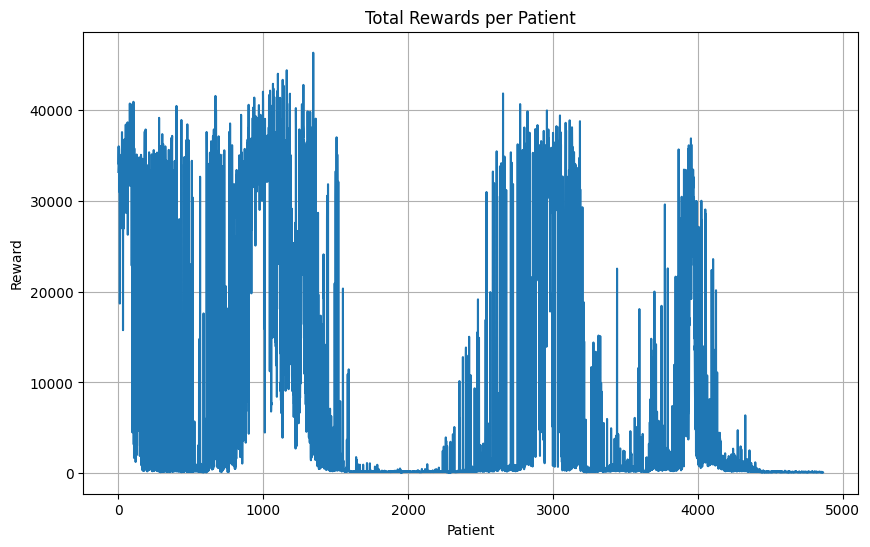

In [ ]:
# Plot total rewards
plt.figure(figsize=(10, 6))
plt.plot(total_rewards, label='Total Reward')
plt.xlabel('Patient')
plt.ylabel('Reward')
plt.title('Total Rewards per Patient')
plt.grid(True)
plt.show()

In [ ]:
# Show distribution of actions recommended
decision_arr = pd.Series(recommended_decision)
decision_arr.describe()

count    4864.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

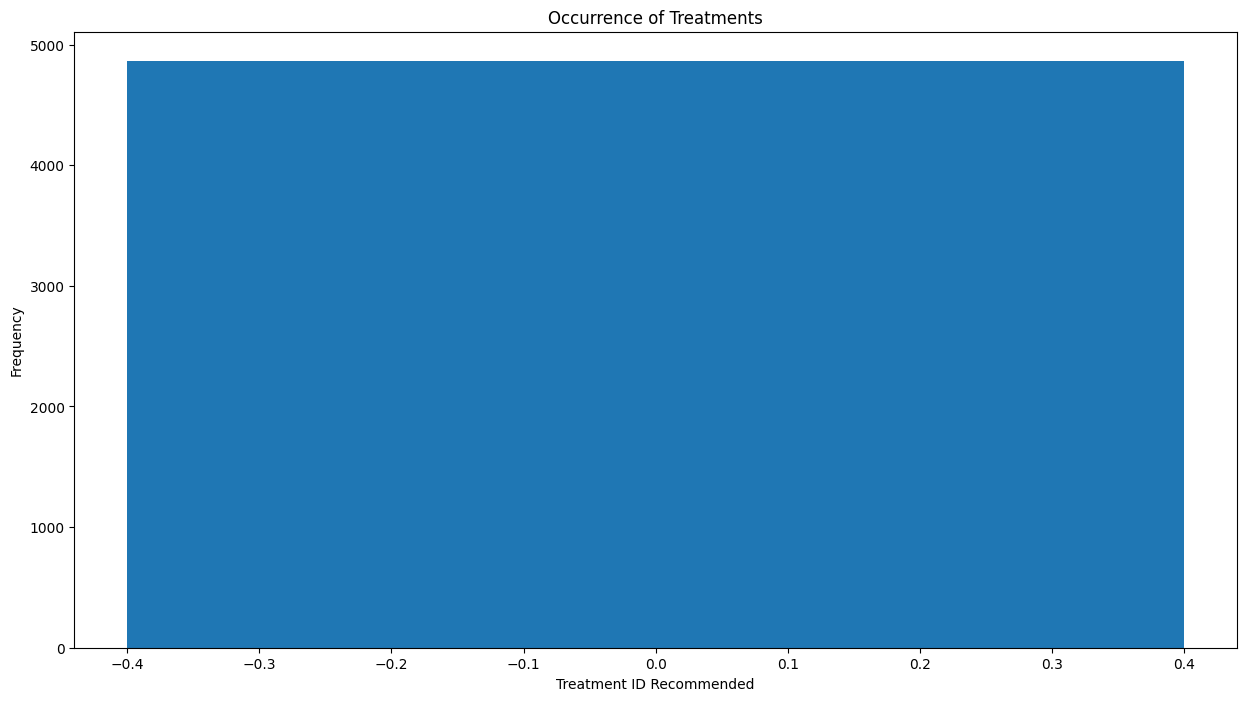

In [ ]:
# Get unique values and their counts
unique_values, counts = np.unique(decision_arr, return_counts=True)

# Create bar plot
plt.figure(figsize=(15, 8))
plt.bar(unique_values, counts)

# Add labels and title
plt.xlabel('Treatment ID Recommended')
plt.ylabel('Frequency')
plt.title('Occurrence of Treatments')

# Show plot
plt.show()

In [ ]:
# Find the index of the maximum count
max_count_index = np.argmax(counts)

# Get the highest occurring value and its count
highest_value = unique_values[max_count_index]
highest_count = counts[max_count_index]

print("Highest occurring treatment:", highest_value)
print("Count:", highest_count)

Highest occurring treatment: 0
Count: 4864


In [ ]:
def inference(patient_details):
    """
    patient_details: 
    {
        CD4 Category: int (0, 1, 2),
        VL Category: int (0, 1, 2),
        Gender: int (0, 1),
        Ethnic: int (0, 1, 2, 3)
    }
    """
    action_space, action_dict = generate_action_space()
    state_space, state_dict = generate_state_space()
    new_state = find_state(patient_details, state_dict)
    state_tensor = np.zeros((1, 72))
    state_tensor[0, new_state] = 1
    state_tensor = torch.FloatTensor(state_tensor).to(device)
    recommended_action_tensor = agent.select_action(state_tensor)
    recommended_action_idx = int(recommended_action_tensor.argmax())
    
    for key, val in action_dict.items():
        if val == recommended_action_idx:
            combo = key
            break
        
    combo_dict = {}
    action_list = ['Base Drug Combo', 'Comp. INI', 'Comp. NNRTI', 'Extra PI', "Extra pk-En"]
    for i, action in enumerate(action_list):
        treatment_str = class_names[action][combo[i]]
        combo_dict[action] = treatment_str

    return combo_dict

inference((0, 0, 0, 0))

ValueError: Expected parameter loc (Tensor of shape (1, 1152)) of distribution Normal(loc: torch.Size([1, 1152]), scale: torch.Size([1, 1152])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan]])